In [1]:
from fastai.vision.all import *

In [2]:
import requests
from pathlib import Path
from PIL import Image
from IPython.display import display

In [3]:
access_key = '0AqOUIfqIcsnJ55rl1gLEj9MoReTY4qDkASS-jl0xy0'  # 替换成你的 key


In [4]:
#key = "0AqOUIfqIcsnJ55rl1gLEj9MoReTY4qDkASS-jl0xy0"

In [5]:
'''
def search_images_unsplash(key, term, count=30):
    url = "https://api.unsplash.com/search/photos"
    params = {
        'query': term,
        'per_page': min(count, 30),
        'client_id': key
    }
    response = requests.get(url, params=params)
    data = response.json()
    return [photo['urls']['regular'] for photo in data.get('results', [])]
'''

In [16]:
def search_images_unsplash_multiple(key, term, total_count=150):
    """
    获取更多图片（分页）
    """
    all_urls = []
    per_page = 30
    pages = (total_count + per_page - 1) // per_page  # 向上取整
    
    for page in range(1, pages + 1):
        url = "https://api.unsplash.com/search/photos"
        params = {
            'query': term,
            'per_page': per_page,
            'page': page,
            'client_id': key
        }
        
        response = requests.get(url, params=params)
        data = response.json()
        
        urls = [photo['urls']['regular'] for photo in data.get('results', [])]
        all_urls.extend(urls)
        
        # 如果没有更多结果就停止
        if len(urls) < per_page:
            break
    
    return all_urls[:total_count]

# 获取150张图片
results = search_images_unsplash_multiple(access_key, 'grizzly bear', total_count=150)
print(f"找到 {len(results)} 张图片")

找到 150 张图片


In [17]:
def download_url(url, dest):
    response = requests.get(url)
    Path(dest).parent.mkdir(parents=True, exist_ok=True)
    with open(dest, 'wb') as f:
        f.write(response.content)

In [7]:
#results = search_images_unsplash(access_key, 'grizzly bear')
#print(f"找到 {len(results)} 张图片")

找到 30 张图片


In [19]:
dest = 'images/grizzly.jpg'
download_url(results[0], dest)

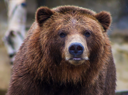

In [20]:
im = Image.open(dest)
im.thumbnail((128, 128))
#im.to_thumb(128,128)
display(im) 

In [21]:
from fastbook import *
search_images_bing


<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [22]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears1')

In [23]:


if not path.exists():
    path.mkdir()

for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_unsplash_multiple(access_key, f'{o} bear')
    download_images(dest, urls=results)

In [25]:
fns = get_image_files(path)
fns


(#447) [Path('bears1/black/03f0dbaf-f52b-47ec-b165-a6881b478a7c.jpg'),Path('bears1/black/04517f5b-6b23-4c53-b00a-abad2ce4f269.jpg'),Path('bears1/black/04f7cf44-2bed-4a9a-bcd1-4353a359cd7a.jpg'),Path('bears1/black/073a4d97-dcc0-438d-98df-155a9f3180ef.jpg'),Path('bears1/black/07e0114d-00ab-4c3a-864c-6cfcf40111c7.jpg'),Path('bears1/black/093a445a-620c-475a-9705-f1e1f9dec4ec.jpg'),Path('bears1/black/09745ff8-4d0d-401e-a0e1-49fcb145ccc0.jpg'),Path('bears1/black/0b390cfe-a611-4c41-b7a8-73e3f9e77ddd.jpg'),Path('bears1/black/0c87f2c2-1fbb-4d41-b0fc-c0500280c544.jpg'),Path('bears1/black/0f04f45e-2593-4556-8ce4-b77cc0b3025b.jpg'),Path('bears1/black/10c296c1-196b-440c-9fa9-e61569fd58f4.jpg'),Path('bears1/black/153e1be1-0010-4978-a297-b083d5a4c5c2.jpg'),Path('bears1/black/163eed50-ad86-4532-a89e-f0301505a63a.jpg'),Path('bears1/black/197cf7e9-2884-4072-a3c1-baf1d2400724.jpg'),Path('bears1/black/19a7006b-b76b-4533-91a7-31c1c1e2dd66.jpg'),Path('bears1/black/1b810d07-e6c7-47bc-95e8-41052e677a82.jpg'),

In [26]:
failed = verify_images(fns)
failed


(#0) []

In [14]:
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])

In [8]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))


In [9]:
dls = bears.dataloaders(path)


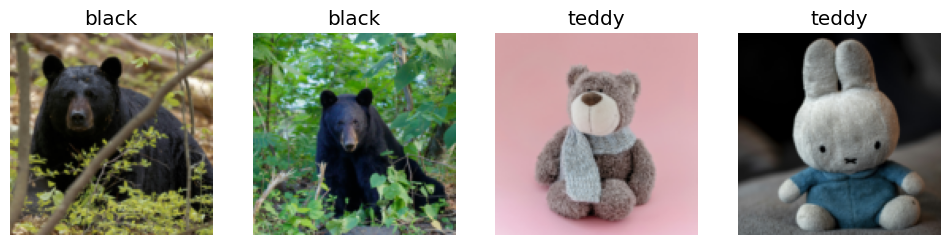

In [24]:
dls.valid.show_batch(max_n=4, nrows=1)

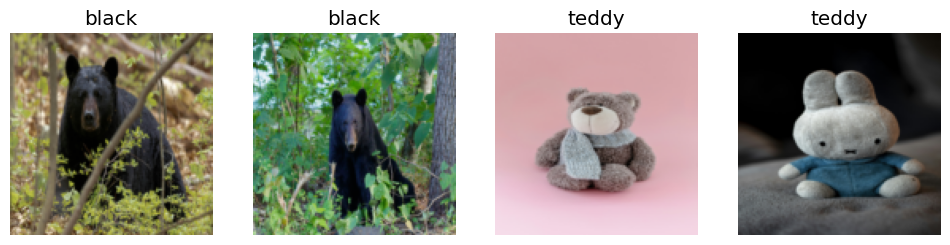

In [18]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


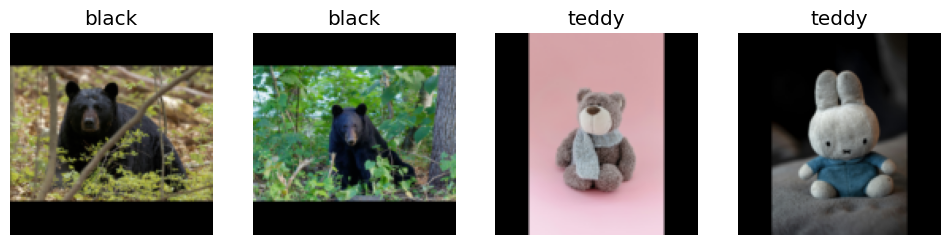

In [19]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)


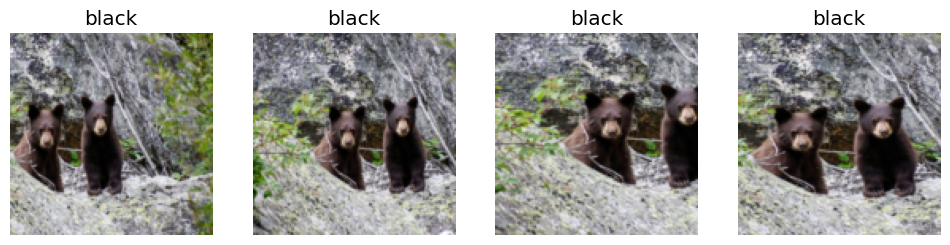

In [25]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)


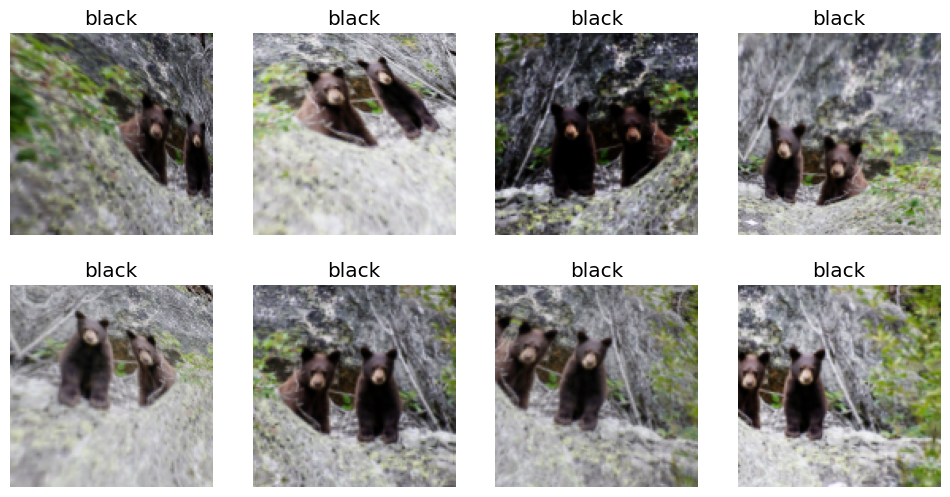

In [26]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)


In [27]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path, device='cuda')


In [28]:
print(f"模型在 GPU 上: {next(learn.model.parameters()).is_cuda}")

模型在 GPU 上: True


In [29]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)



C:\ProgramData\anaconda3\envs\AI-learning\Lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,1.624710,0.662084,0.202247,01:38


epoch,train_loss,valid_loss,error_rate,time
0,0.701108,0.634846,0.179775,01:38
1,0.609071,0.756480,0.202247,01:38
2,0.485392,0.745550,0.202247,01:38
3,0.426901,0.735933,0.202247,01:38


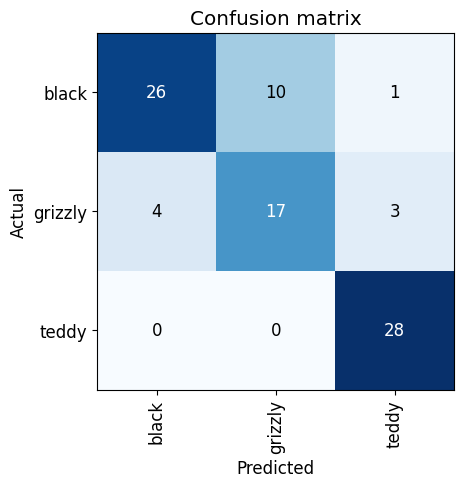

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

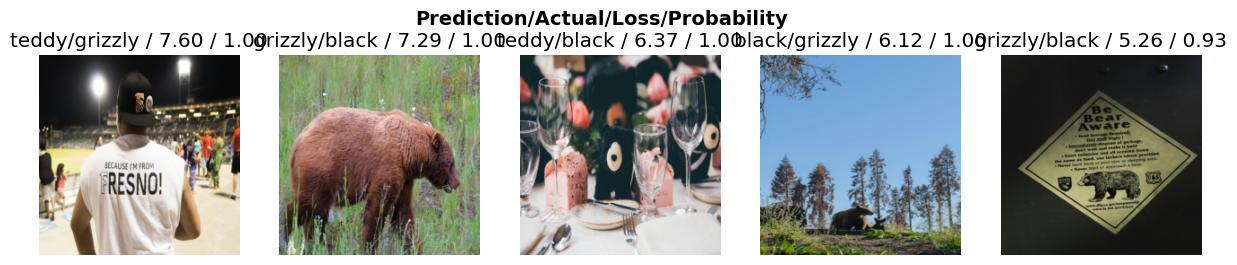

In [31]:
interp.plot_top_losses(5, nrows=1)

In [33]:
from fastai.vision.widgets import *

In [34]:
cleaner = ImageClassifierCleaner(learn)
cleaner


In [35]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [36]:
learn.export()


In [37]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [40]:
learn_inf = load_learner(path/'export.pkl')

C:\ProgramData\anaconda3\envs\AI-learning\Lib\site-packages\fastai\learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [41]:
learn_inf.predict('images/grizzly.jpg')


('grizzly', tensor(1), tensor([3.5262e-03, 9.9635e-01, 1.2612e-04]))

In [42]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

In [43]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [53]:
type(btn_upload)

ipywidgets.widgets.widget_upload.FileUpload

In [45]:
img = PILImage.create(btn_upload.data[-1])

In [55]:
??PILImage.create

Signature:
PILImage.create(
    fn: pathlib.Path | str | torch.Tensor | numpy.ndarray | bytes | PIL.Image.Image,
    **kwargs,
)
Source:   
    @classmethod
    def create(cls, fn:Path|str|Tensor|ndarray|bytes|Image.Image, **kwargs):
        "Return an Image from `fn`"
        if isinstance(fn,TensorImage): fn = fn.permute(1,2,0).type(torch.uint8)
        if isinstance(fn,TensorMask): fn = fn.type(torch.uint8)
        if isinstance(fn,Tensor): fn = fn.numpy()
        if isinstance(fn,ndarray): return cls(Image.fromarray(fn))
        if isinstance(fn,bytes): fn = io.BytesIO(fn)
        if isinstance(fn,Image.Image): return cls(fn)
        return cls(load_image(fn, **merge(cls._open_args, kwargs)))
File:      c:\programdata\anaconda3\envs\ai-learning\lib\site-packages\fastai\vision\core.py
Type:      method

In [46]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [47]:
pred,pred_idx,probs = learn_inf.predict(img)

In [48]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred


Label(value='Prediction: grizzly; Probability: 0.9963')

In [49]:
btn_run = widgets.Button(description='Classify')
btn_run


Button(description='Classify', style=ButtonStyle())

In [51]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
btn_run.on_click(on_click_classify)


In [52]:
VBox([widgets.Label('Select your bear!'),
      btn_upload, btn_run, out_pl, lbl_pred])